In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import statsmodels.api as sma
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.stats import shapiro, kstest, ttest_ind, mannwhitneyu, fisher_exact, chi2_contingency, kruskal, wilcoxon, ttest_rel
from statsmodels.stats.contingency_tables import mcnemar, cochrans_q
from pandas.api.types import CategoricalDtype

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

### Импорт таблицы и удаление лишних переменных (открытых вопросов)

In [3]:
df = pd.read_excel('C:/Users/lizag/OneDrive/Рабочий стол/Управление талантами/Финальный проект/DBTC1.xlsx', sheet_name = 'Answers')

df = df.drop(columns = ['YouAnswer', 'IFoundOutPositiveOnlyAsEmployee', 'IFoundOutNegativeOnlyAsEmployee', 'WhyIchooseCompany', 'WhyIrecommendCompany', 'WhatItellAboutComp', 'Keyword1', 'Keyword2', 'Keyword3'])

### Пропущенные значения

In [9]:
nulls = df.isna().sum().to_frame().reset_index()
nulls['Доля пропущенных, %'] = round(nulls.iloc[:,1] / df.shape[0]*100, 1)
nulls.columns = ['Фактор', 'Количество пропущенных, n', 'Доля пропущенных, %']
nulls.sort_values('Доля пропущенных, %', ascending = False).head()

,Фактор,"Количество пропущенных, n","Доля пропущенных, %"
102,IllrecommendcompanyAsEmployer,8,1.4
0,City,4,0.7
48,ExistsWorkInUnitedTeam,1,0.2
2,Age,0,0.0
65,ImportantJobImportanceColleaguesManagerAppec,0,0.0


### Графики распределения

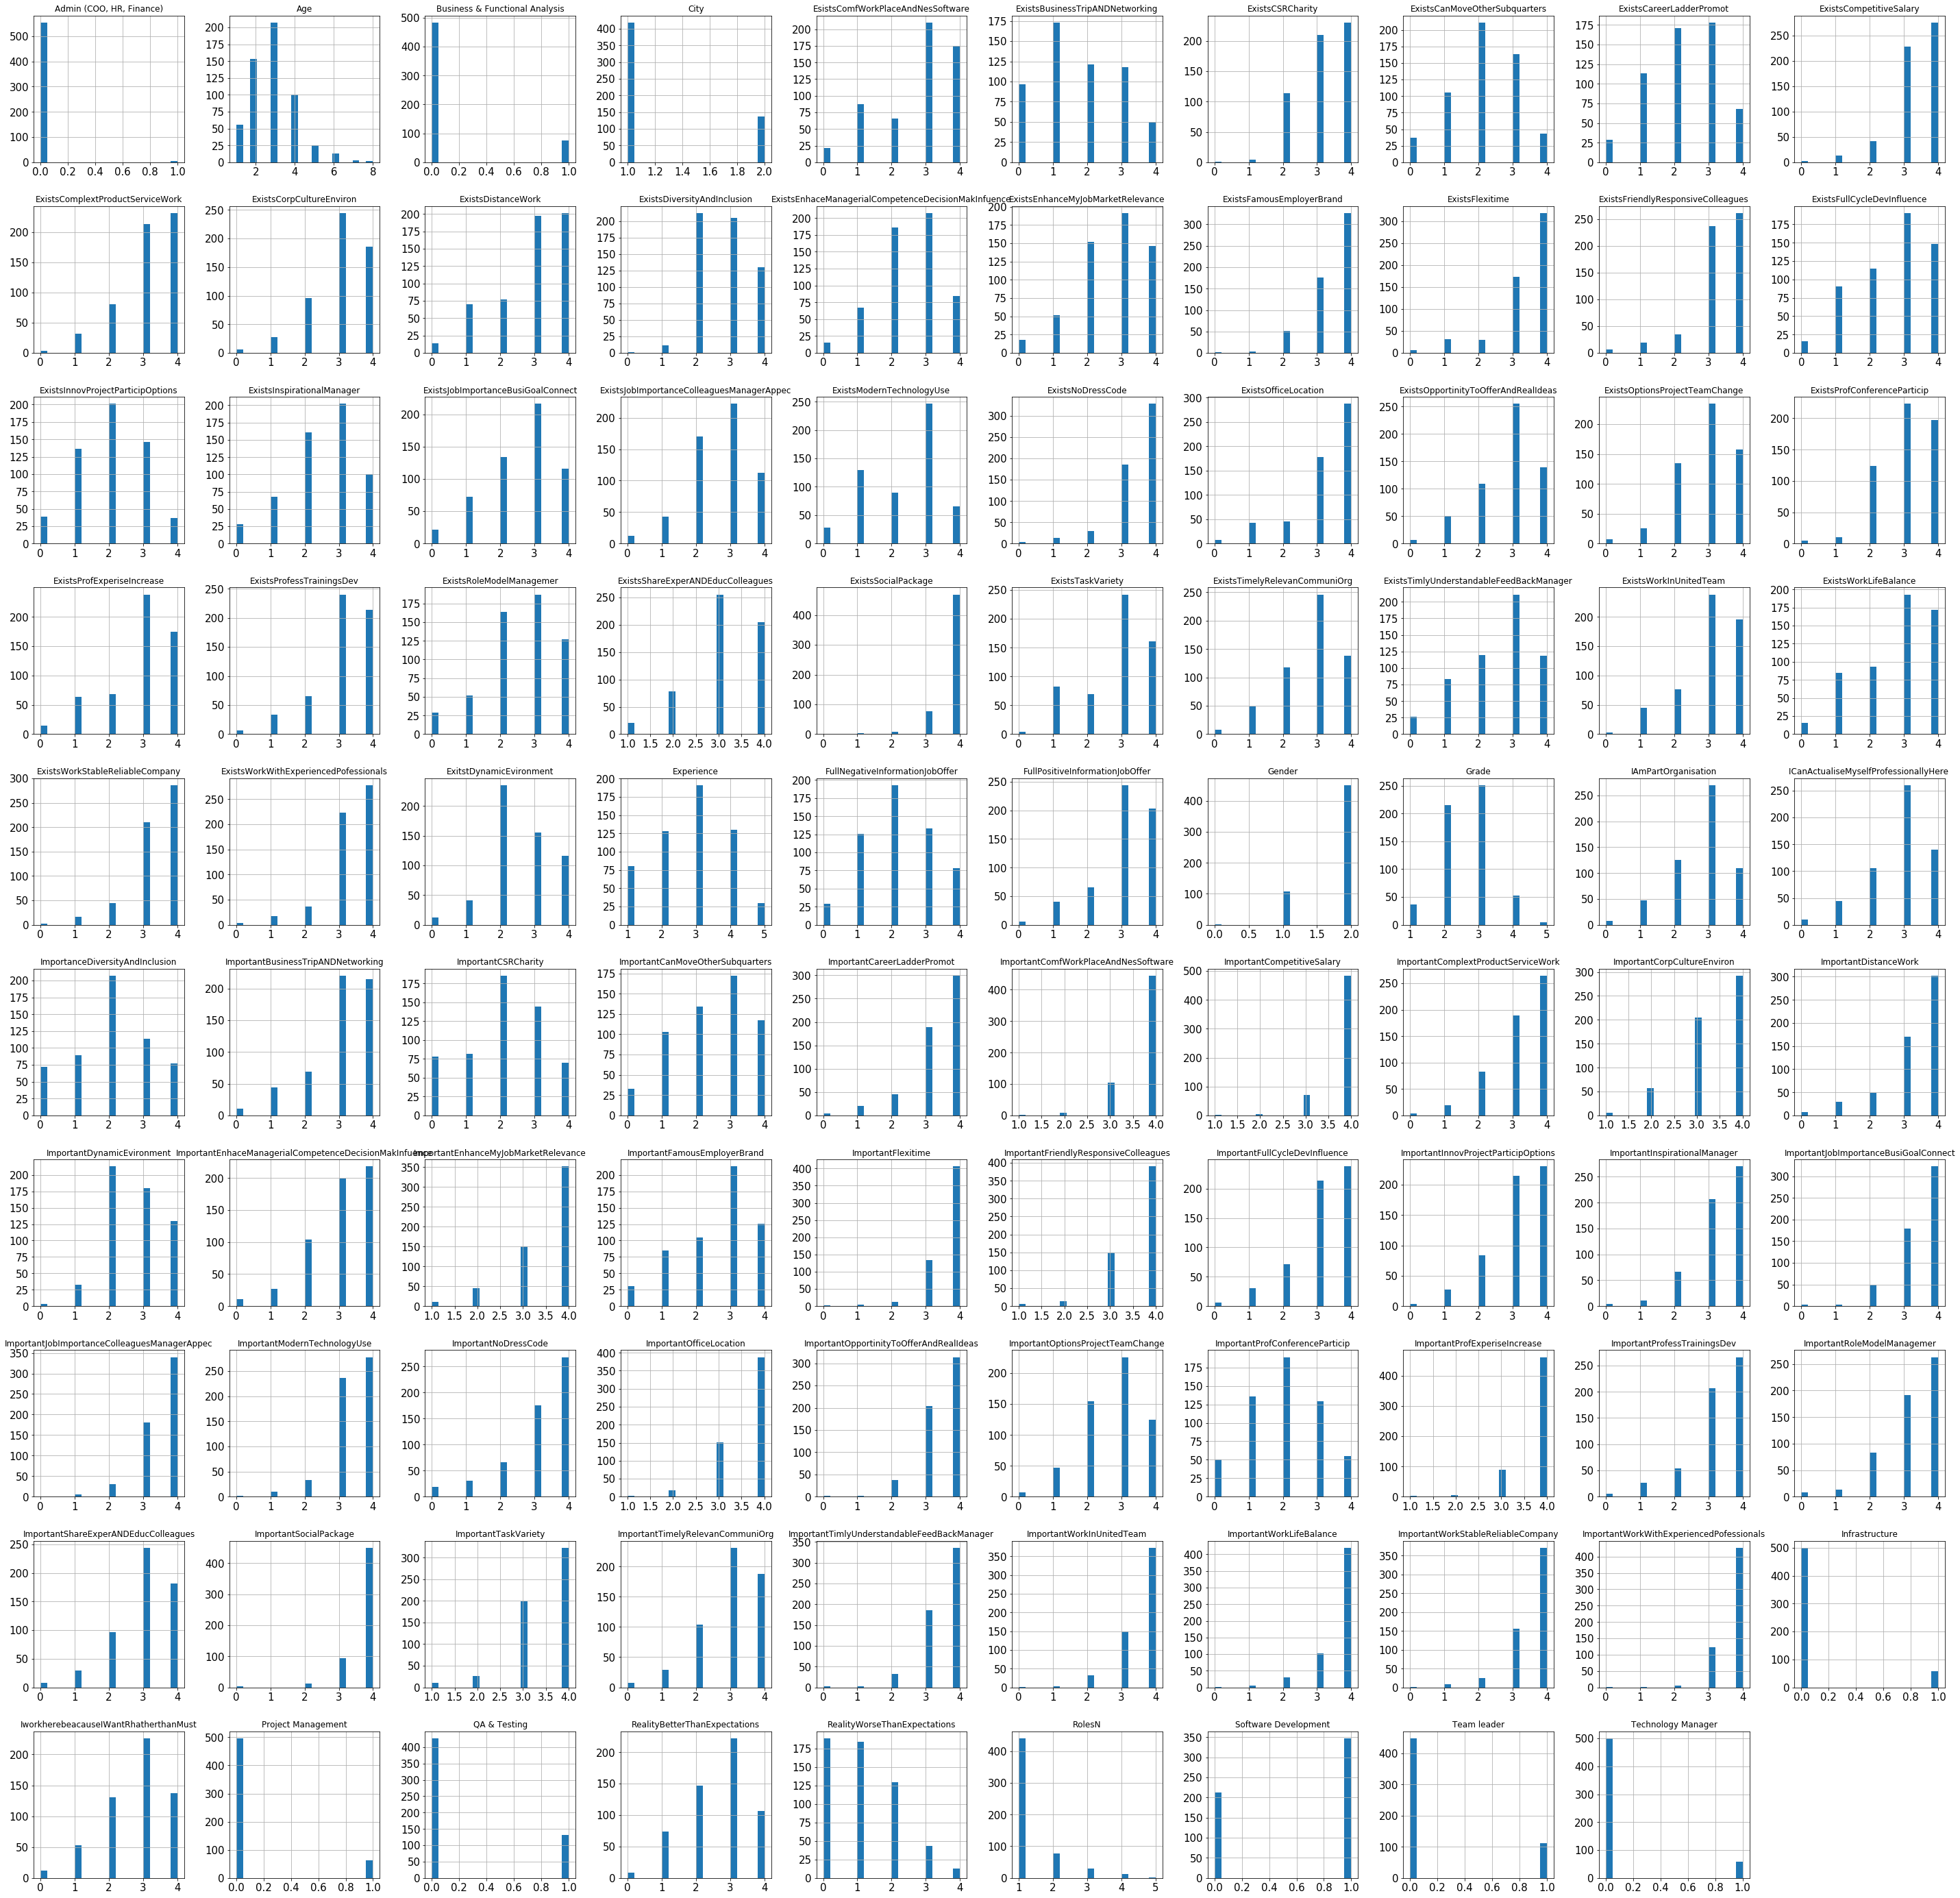

In [7]:
df.hist(figsize=(50, 50), bins=20, xlabelsize=15, ylabelsize=15);


## Описательный анализ

In [3]:
df1 = df.drop(columns = ['Age', 'Experience', 'Talents'])

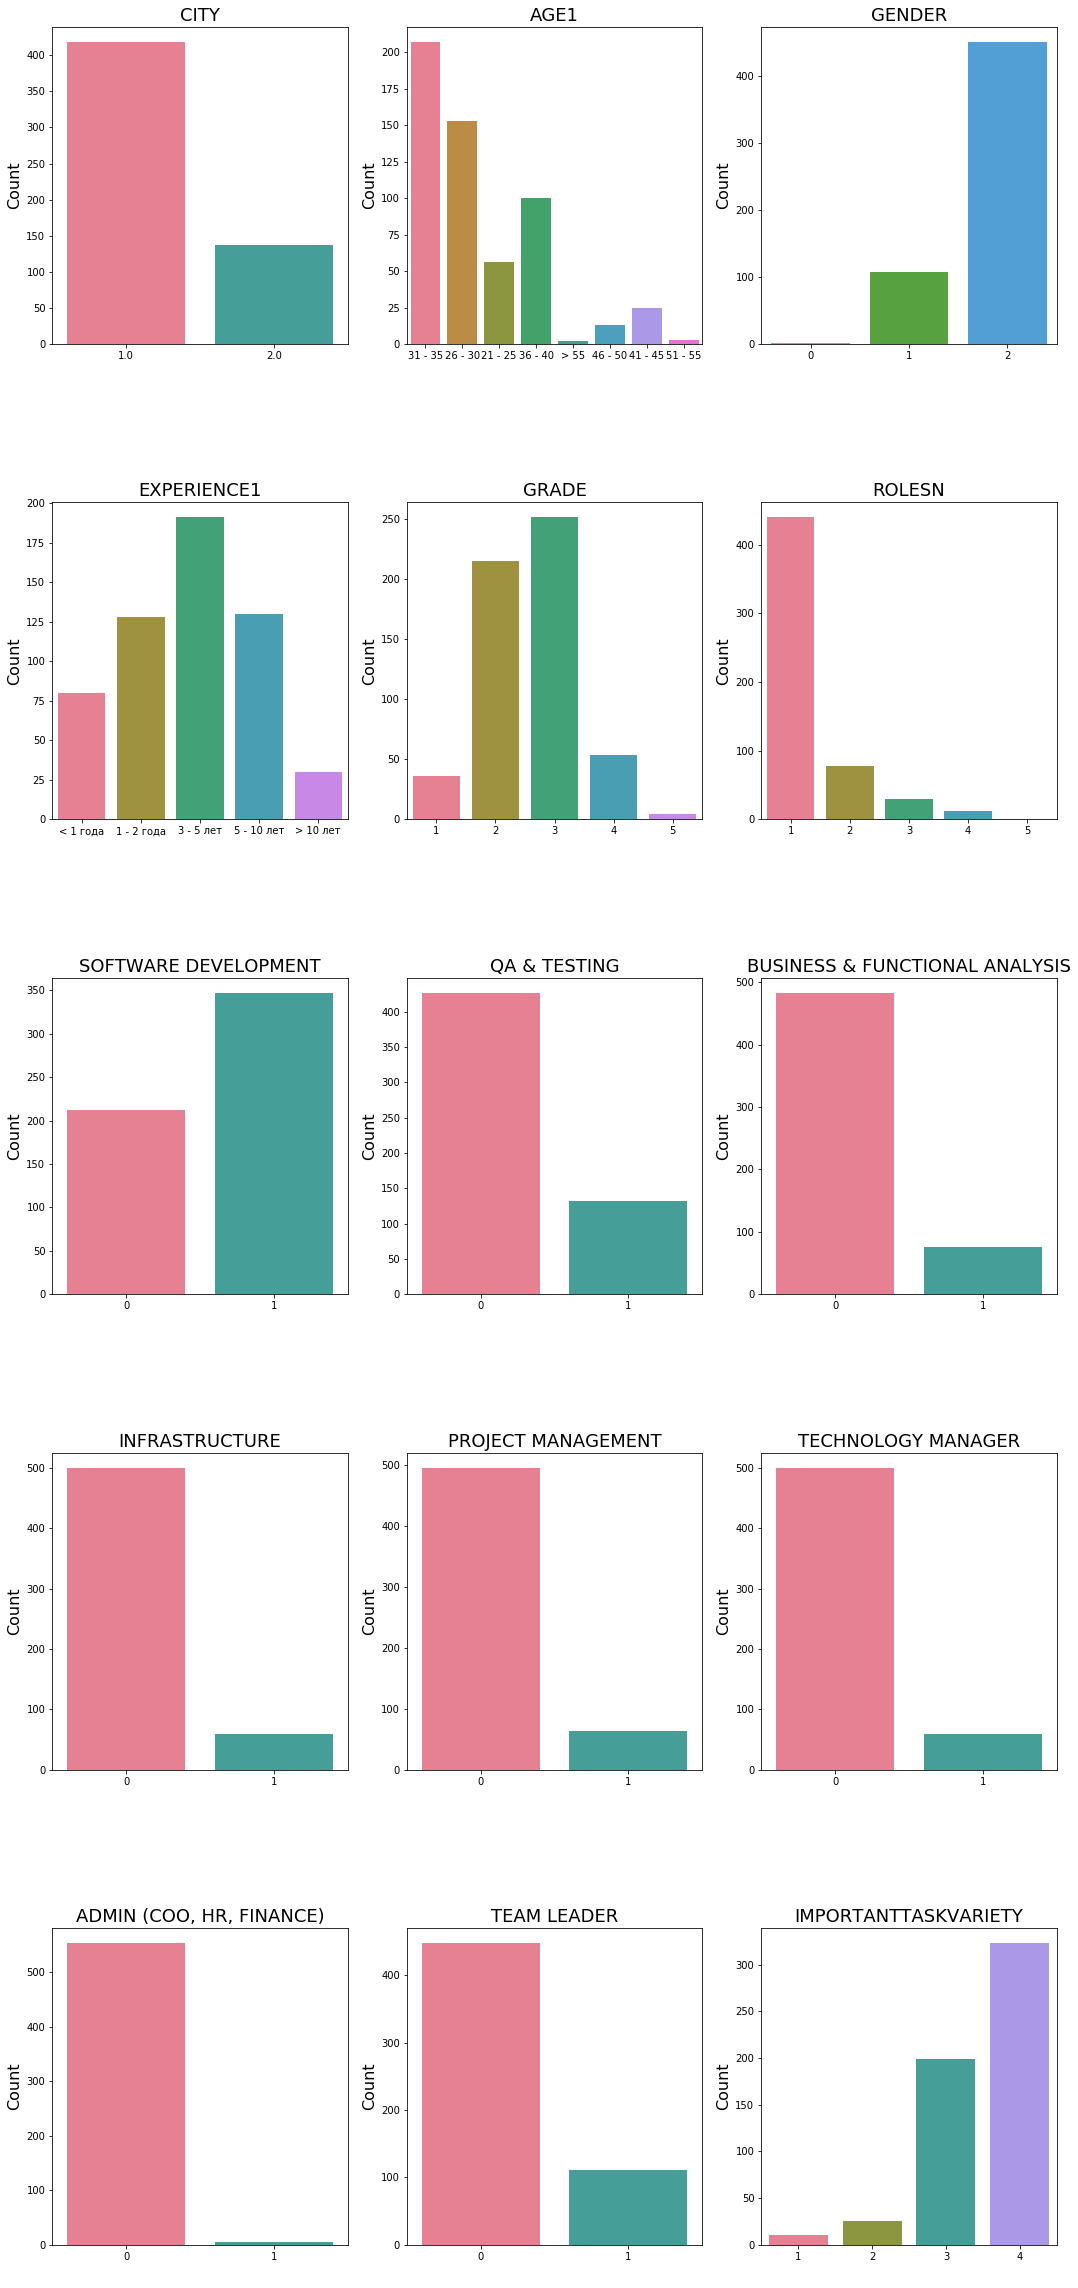

In [36]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18,35))
fig.subplots_adjust(hspace=0.5, bottom=0)

for ax, catplot in zip(axes.flatten(), df1):
        sns.countplot(x=catplot, data=df1, ax=ax, palette='husl')
        ax.set_title(catplot.upper(), fontsize=18)
        ax.set_ylabel('Count', fontsize=16)
        ax.set_xlabel(' ', fontsize=15)

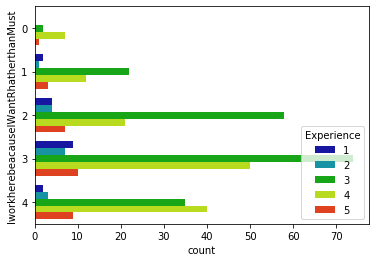

In [7]:
sns.countplot(y='IworkherebeacauseIWantRhatherthanMust', data=df[df['Talents'] == 0], hue='Experience', palette='nipy_spectral')

###  Создание дамми-переменных

In [4]:
"""
Преобразование в dummy - переменные с сохранением NA, если они присутствуют. 
"""

def dummy_serie(df, col):
    tab = pd.get_dummies(df[col], prefix = col)
    tab.loc[df[col].isnull(), tab.columns.str.startswith(str(col))] = np.nan
    return(tab)

def dummification(df, cat_vars):
    data = df[cat_vars]
    tab = pd.DataFrame()
    for col in data:
        tab = pd.concat([dummy_serie(df, col), tab], axis = 1)
    
    tab = tab[tab.columns[::-1]]
    df =df.drop(columns = cat_vars)
    df = pd.concat([df, tab], axis = 1)
        
    return(df)

In [5]:
cat_vars = ['City', 'Age1', 'Gender', 'Experience1']
df = dummification(df, cat_vars)
df = df.drop(columns = 'Gender_2')


### Описательные статистики по всей группе

Распределение везде ненормальное

In [20]:
"""
summary
"""

def to_array(df, col):
    return df[[col]].dropna().to_numpy()[:,0]


def cat_perc(var):
    n = round(np.sum(var),0)
    percents = round(n / len(var)*100, 1)
    return n, percents


def summ_numer(var):
    avg = np.mean(var) 
    sd = np.std(var) 
    mn = np.min(var) 
    mx = round(np.max(var),1)
    md = round(np.median(var),1)
    c25 = np.percentile(var, 25)
    c75 = np.percentile(var, 75)
    c2_5 = np.percentile(var, 2.5)
    c975 = np.percentile(var, 97.5)
    return avg, sd, mn, mx, md, c25, c75, c2_5, c975    

def summary_all(df, save_tab = False):
    summarize = pd.DataFrame()
    for col in df:
        v = df[col].name
        var = to_array(df, col)
        if len(np.unique(var)) == 1:
            vartype = 'Уникальная'
            n = round(len(var),0)
            med = avg = minn = maxx = sh = c2_5 = c975 = np.unique(var)
            percents = '-'
            N = len(var)
        elif len(np.unique(var)) < 3:
            v = df[col].name
            vartype = 'Категориальная'
            n, percents = cat_perc(var)
            percents = str(percents).join(' %')
            med = avg = minn = maxx = sh = c2_5 = c975 = '-'
            N = len(var)
        else:
            v = df[col].name
            vartype = 'Числовая'
            n = round(len(var),0)
            percents = '-'
            avg, sd, minn, maxx, md, c25, c75, c2_5, c975 = summ_numer(var)
            avg = ''.join([str(round(avg, 1)), ' ± ', str(round(sd, 1))])
            med = ''.join([str(round(md,1)), ' [',str(round(c25,1)),'; ',str(round(c75, 1)),']'])
            sh = kstest(var, cdf='norm')[1]
            if sh >= 0.001:
                sh = '{0:.3f}'.format(sh)
            else:
                sh = '< 0.001'                
            N = len(var)
            
        summarize = summarize.append({'Фактор': v, 'Тип': vartype, 'N':'% 6.0f' % N, 'Количество': '% 6.0f' % n, \
            'Доля, %': percents,'Медиана и 25/75 перцентили': med, 'Среднее и ст. отклонение': avg , \
            'Мин': minn, 'Макс': maxx, 'Критерий КС, р': sh, '2,5%': c2_5, '97,5%':c975}, ignore_index=True)
    summarize = summarize.reindex(columns=['Фактор', 'Тип', 'N','Количество', 'Доля, %', 'Мин', '2,5%','Медиана и 25/75 перцентили', '97,5%','Макс', 'Среднее и ст. отклонение', 'Критерий КС, р'])

    if save_tab == True:
        return pd.DataFrame.to_excel(summarize, 'Описательные статистики.xlsx')
    else:
        return summarize
    
def summary_num(df, save_tab = False):
    summarize = pd.DataFrame()
    for col in df:
        v = df[col].name
        var = to_array(df, col)
        if len(np.unique(var)) == 1:
            vartype = 'Уникальная'
            n = round(len(var),0)
            med = avg = minn = maxx = sh = c2_5 = c975 = np.unique(var)
        else:
            v = df[col].name
            vartype = 'Числовая'
            n = round(len(var),0)
            percents = '-'
            avg, sd, minn, maxx, md, c25, c75, c2_5, c975 = summ_numer(var)
            avg = ''.join([str(round(avg, 1)), ' ± ', str(round(sd, 1))])
            med = ''.join([str(round(md,1)), ' [',str(round(c25,1)),'; ',str(round(c75, 1)),']'])
            sh = kstest(var, cdf='norm')[1]
            if sh >= 0.001:
                sh = '{0:.3f}'.format(sh)
            else:
                sh = '< 0.001'                
            N = len(var)
            
        summarize = summarize.append({'Фактор': v, 'Тип': vartype, 'N':'% 6.0f' % N, 'Количество': '% 6.0f' % n, \
            'Медиана и 25/75 перцентили': med, 'Среднее и ст. отклонение': avg , \
            'Мин': minn, 'Макс': maxx, 'Критерий КС, р': sh, '2,5%': c2_5, '97,5%':c975}, ignore_index=True)
    summarize = summarize.reindex(columns=['Фактор', 'Тип', 'N','Количество', 'Мин', '2,5%','Медиана и 25/75 перцентили', '97,5%','Макс', 'Среднее и ст. отклонение', 'Критерий КС, р'])

    if save_tab == True:
        return pd.DataFrame.to_excel(summarize, 'Описательные статистики.xlsx')
    else:
        return summarize    

def summary_cat(df, save_tab = False):
    summarize = pd.DataFrame()
    for col in df:
        v = df[col].name
        var = to_array(df, col)
        n, percents = cat_perc(var)
        percents = str(percents).join(' %')
        N = len(var)
            
        summarize = summarize.append({'Фактор': v, 'N':'% 6.0f' % N, 'Количество': '% 6.0f' % n, 'Доля, %': percents}, ignore_index=True)
    summarize = summarize.reindex(columns=['Фактор', 'N','Количество', 'Доля, %'])

    if save_tab == True:
        return pd.DataFrame.to_excel(summarize, 'Описательные статистики.xlsx')
    else:
        return summarize
    
def summary(df, save_tab = False, method = 'all'):
    df = df
    save_tab = save_tab
    
    if method == 'all':
        return(summary_all(df, save_tab = save_tab))
    elif method == 'num':
        return(summary_num(df, save_tab = save_tab))
    elif method == 'cat':
        return(summary_cat(df, save_tab = save_tab))
    else:
        return(print('ERROR: method is `all` or `num` or `cat`'))


"""
compare
"""


def compare_cat(x_var, y_var):
    gr1obs = np.sum(x_var)
    gr2obs = np.sum(y_var)
    gr1exp = len(x_var) - gr1obs
    gr2exp = len(y_var) - gr2obs
    return gr1obs, gr2obs, gr1exp, gr2exp


def compare_numer_unnorm(x_var, y_var):
    gr1obs = round(np.median(x_var),2)
    gr2obs = round(np.median(y_var),2)
    cent1 = np.percentile(x_var, [25,75])
    cent2 = np.percentile(y_var, [25,75])
    return gr1obs, gr2obs, cent1, cent2


def compare_numer_norm(x_var, y_var):
    gr1obs = round(np.median(x_var),2)
    gr2obs = round(np.median(y_var),2)
    sd1 = np.std(x_var)
    sd2 = np.std(y_var)
    return gr1obs, gr2obs, sd1, sd2


def compare_all(df, group, gr_id_1 = 0, gr_id_2 = 1, name_1 = 'Группа 0', name_2 = 'Группа 1', test = 'mw', save_tab = False):

    x = df.loc[df[group] == gr_id_1].drop(columns = group)
    y = df.loc[df[group] == gr_id_2].drop(columns = group)

    comparison = pd.DataFrame()

    for col in x:
        x_var = to_array(x, col)
        y_var = to_array(y, col)
        v = df[col].name
        if len(np.unique(df[col])) < 3:
                 
            gr1obs, gr2obs, gr1exp, gr2exp = compare_cat(x_var, y_var)
                # в таблицу идут:
            p_val = round(fisher_exact(np.array([[gr1obs, gr2obs], [gr1exp, gr2exp]]))[1], 3)
            p1 = ''.join([str('{0:.0f}'.format(gr1obs)), " ", " (", str(round(gr1obs/len(x_var)*100,1))," %)"])
            p2 = ''.join([str('{0:.0f}'.format(gr2obs)), " ", " (", str(round(gr2obs/len(y_var)*100,1))," %)"])
            Nx = len(x_var)
            Ny = len(y_var)
        else:
            v = df[col].name
            if test == 'mw':
                gr1obs, gr2obs, cent1, cent2 = compare_numer_unnorm(x_var, y_var)
                    # в таблицу идут:
                p_val = round(mannwhitneyu(x[col], y[col])[1], 3)
                p1 = ''.join([str(gr1obs), " [", str(round(cent1[0],2)), "; ", str(round(cent1[1],2)), "]"])
                p2 = ''.join([str(gr2obs), " [", str(round(cent2[0],2)), "; ", str(round(cent2[1],2)), "]"])
                Nx = len(x_var)
                Ny = len(y_var)
            elif test == 'tt':
                gr1obs, gr2obs, sd1, sd2 = compare_numer_norm(x_var, y_var)
                p_val = round(ttest_ind(x_var, y_var, equal_var = False)[1], 3)
                p1 = ''.join([str(gr1obs), " ± ", str(round(sd1, 1))])
                p2 = ''.join([str(gr2obs), " ± ", str(round(sd2, 1))])
                Nx = len(x_var)
                Ny = len(y_var)
            else:
                print('ERROR: test is mw or tt (Welch)')

        comparison = comparison.append({'Фактор': v, name_1: p1, name_2: p2,'p_val': p_val, 'N 0': '{0:.0f}'.format(Nx), 'N 1' : '{0:.0f}'.format(Ny)}, ignore_index=True) #
        
    comparison = comparison.reindex(columns=['Фактор', 'N 0','N 1',name_1, name_2, 'p_val'])# 

    if save_tab == True:
        return pd.DataFrame.to_excel(comparison, 'Сравнение по группам.xlsx')
    else:
        return comparison
    

def compare_num(df, group, gr_id_1 = 0, gr_id_2 = 1, name_1 = 'Группа 0', name_2 = 'Группа 1', test = 'mw', save_tab = False):

    x = df.loc[df[group] == gr_id_1].drop(columns = group)
    y = df.loc[df[group] == gr_id_2].drop(columns = group)

    comparison = pd.DataFrame()

    for col in x:
        J = len(list(x.columns))
        x_var = to_array(x, col)
        y_var = to_array(y, col)
        v = df[col].name
        if test == 'mw':
                
            gr1obs, gr2obs, cent1, cent2 = compare_numer_unnorm(x_var, y_var)
                # в таблицу идут:
            p_val = round(mannwhitneyu(x[col], y[col])[1], 3)
            p1 = ''.join([str(gr1obs), " [", str(round(cent1[0],2)), "; ", str(round(cent1[1],2)), "]"])
            p2 = ''.join([str(gr2obs), " [", str(round(cent2[0],2)), "; ", str(round(cent2[1],2)), "]"])
            Nx = len(x_var)
            Ny = len(y_var)
        elif test == 'tt':
            v = df[col].name
            gr1obs, gr2obs, sd1, sd2 = compare_numer_norm(x_var, y_var)
            p_val = round(ttest_ind(x_var, y_var, equal_var = False)[1], 3)
            p1 = ''.join([str(gr1obs), " ± ", str(round(sd1, 1))])
            p2 = ''.join([str(gr2obs), " ± ", str(round(sd2, 1))])
            Nx = len(x_var)
            Ny = len(y_var)
        else:
            print('ERROR: test is mw or tt (Welch)')

        comparison = comparison.append({'Фактор': v, name_1: p1, name_2: p2,'p_val': p_val, 'N 0': Nx, 'N 1' : Ny}, ignore_index=True)
        
    comparison = comparison.reindex(columns=['Фактор', 'N 0','N 1', name_1, name_2, 'p_val'])

    if save_tab == True:
        return pd.DataFrame.to_excel(comparison, 'Сравнение по группам.xlsx')
    else:
        return comparison

def compare_fac(df, group, gr_id_1 = 0, gr_id_2 = 1, name_1 = 'Группа 0', name_2 = 'Группа 1', save_tab = False):

    x = df.loc[df[group] == gr_id_1].drop(columns = group)
    y = df.loc[df[group] == gr_id_2].drop(columns = group)

    comparison = pd.DataFrame()

    for col in x:
        v = df[col].name
        x_var = to_array(x, col)
        y_var = to_array(y, col)
        gr1obs, gr2obs, gr1exp, gr2exp = compare_cat(x_var, y_var)
                # в таблицу идут:
        p_val = round(fisher_exact(np.array([[gr1obs, gr2obs], [gr1exp, gr2exp]]))[1], 3)
        p1 = ''.join([str('{0:.0f}'.format(gr1obs)), " ", " (", str(round(gr1obs/len(x_var)*100,1))," %)"])
        p2 = ''.join([str('{0:.0f}'.format(gr2obs)), " ", " (", str(round(gr2obs/len(y_var)*100,1))," %)"])
        Nx = len(x_var)
        Ny = len(y_var)

        comparison = comparison.append({'Фактор': v, name_1: p1, name_2: p2,'p_val': p_val, 'N 0': '{0:.0f}'.format(Nx), 'N 1' : '{0:.0f}'.format(Ny)}, ignore_index=True) #
        
    comparison = comparison.reindex(columns=['Фактор', 'N 0','N 1',name_1, name_2, 'p_val'])# 

    if save_tab == True:
        return pd.DataFrame.to_excel(comparison, 'Сравнение по группам.xlsx')
    else:
        return comparison
    
    
def compare(df, group, gr_id_1 = 0, gr_id_2 = 1, name_1 = 'Группа 0', name_2 = 'Группа 1', test = 'mw', save_tab = False, method = 'all'):
    
    df = df
    group = group
    gr_id_1 = gr_id_1
    gr_id_2 = gr_id_2
    name_1 = name_1
    name_2 = name_2
    test = test
    save_tab = save_tab
    method = method
    
    if method == 'all':
        return(compare_all(df, group, gr_id_1, gr_id_2, name_1, name_2, test, save_tab))
    elif method == 'num':
        return(compare_num(df, group, gr_id_1, gr_id_2, name_1, name_2, test, save_tab))
    elif method == 'fact':
        return(compare_fac(df, group, gr_id_1, gr_id_2, name_1, name_2, save_tab))
    else:
        return(print('ERROR: method is `all` or `num` or `fact`'))

In [21]:
summary(df)

,Фактор,Тип,N,Количество,"Доля, %",Мин,"2,5%",Медиана и 25/75 перцентили,"97,5%",Макс,Среднее и ст. отклонение,"Критерий КС, р"
0,Age,Числовая,559,559,-,1,1,3.0 [2.0; 4.0],6,8,2.9 ± 1.2,< 0.001
1,Experience,Числовая,559,559,-,1,1,3.0 [2.0; 4.0],5,5,2.8 ± 1.1,< 0.001
2,Talents,Категориальная,559,176,31.5%,-,-,-,-,-,-,-
3,Grade,Числовая,559,559,-,1,1,3.0 [2.0; 3.0],4,5,2.6 ± 0.8,< 0.001
4,RolesN,Числовая,559,559,-,1,1,1.0 [1.0; 1.0],3,5,1.3 ± 0.7,< 0.001
5,Software Development,Категориальная,559,347,62.1%,-,-,-,-,-,-,-
6,QA & Testing,Категориальная,559,132,23.6%,-,-,-,-,-,-,-
7,Business & Functional Analysis,Категориальная,559,76,13.6%,-,-,-,-,-,-,-
8,Infrastructure,Категориальная,559,59,10.6%,-,-,-,-,-,-,-
9,Project Management,Категориальная,559,63,11.3%,-,-,-,-,-,-,-


## для не талантов

In [22]:
summary(df[df['Talents'] == 0])


,Фактор,Тип,N,Количество,"Доля, %",Мин,"2,5%",Медиана и 25/75 перцентили,"97,5%",Макс,Среднее и ст. отклонение,"Критерий КС, р"
0,Age,Числовая,383,383,-,1,2,3.0 [3.0; 4.0],6,8,3.3 ± 1.1,< 0.001
1,Experience,Числовая,383,383,-,1,1,3.0 [3.0; 4.0],5,5,3.4 ± 0.9,< 0.001
2,Talents,Уникальная,383,383,-,[0],[0],[0],[0],[0],[0],[0]
3,Grade,Числовая,383,383,-,1,2,3.0 [2.0; 3.0],4,5,2.9 ± 0.7,< 0.001
4,RolesN,Числовая,383,383,-,1,1,1.0 [1.0; 2.0],4,5,1.4 ± 0.8,< 0.001
5,Software Development,Категориальная,383,241,62.9%,-,-,-,-,-,-,-
6,QA & Testing,Категориальная,383,78,20.4%,-,-,-,-,-,-,-
7,Business & Functional Analysis,Категориальная,383,61,15.9%,-,-,-,-,-,-,-
8,Infrastructure,Категориальная,383,43,11.2%,-,-,-,-,-,-,-
9,Project Management,Категориальная,383,55,14.4%,-,-,-,-,-,-,-


## для талантов

In [23]:
summary(df[df['Talents'] == 1])

,Фактор,Тип,N,Количество,"Доля, %",Мин,"2,5%",Медиана и 25/75 перцентили,"97,5%",Макс,Среднее и ст. отклонение,"Критерий КС, р"
0,Age,Числовая,176,176,-,1,1,2.0 [1.0; 3.0],3,3,2.1 ± 0.8,< 0.001
1,Experience,Категориальная,176,289,164.2%,-,-,-,-,-,-,-
2,Talents,Уникальная,176,176,-,[1],[1],[1],[1],[1],[1],[1]
3,Grade,Числовая,176,176,-,1,1,2.0 [2.0; 2.0],3,3,2.0 ± 0.6,< 0.001
4,RolesN,Числовая,176,176,-,1,1,1.0 [1.0; 1.0],2,4,1.1 ± 0.5,< 0.001
5,Software Development,Категориальная,176,106,60.2%,-,-,-,-,-,-,-
6,QA & Testing,Категориальная,176,54,30.7%,-,-,-,-,-,-,-
7,Business & Functional Analysis,Категориальная,176,15,8.5%,-,-,-,-,-,-,-
8,Infrastructure,Категориальная,176,16,9.1%,-,-,-,-,-,-,-
9,Project Management,Категориальная,176,8,4.5%,-,-,-,-,-,-,-


## Сравненительный анализ групп

#### Баллы - по U-критерию Манна-Уитни, категории - по точному тесту Фишера

In [54]:
tab = compare(df, group = 'Talents', name_1 = 'Others', name_2 = 'Young talents')
tab

,Фактор,N 0,N 1,Others,Young talents,p_val
0,Age,383,176,3.0 [3.0; 4.0],2.0 [1.0; 3.0],0.000
1,Experience,383,176,3.0 [3.0; 4.0],2.0 [1.0; 2.0],0.000
2,Grade,383,176,3.0 [2.0; 3.0],2.0 [2.0; 2.0],0.000
3,RolesN,383,176,1.0 [1.0; 2.0],1.0 [1.0; 1.0],0.000
4,Software Development,383,176,241 (62.9 %),106 (60.2 %),0.574
5,QA & Testing,383,176,78 (20.4 %),54 (30.7 %),0.010
6,Business & Functional Analysis,383,176,61 (15.9 %),15 (8.5 %),0.017
7,Infrastructure,383,176,43 (11.2 %),16 (9.1 %),0.553
8,Project Management,383,176,55 (14.4 %),8 (4.5 %),0.000
9,Technology Manager,383,176,54 (14.1 %),5 (2.8 %),0.000


In [68]:
tab.to_excel('tabgroups.xlsx')

## Вывод только значимых различий:

In [55]:
tab[tab['p_val'] < 0.05].sort_values('p_val')


,Фактор,N 0,N 1,Others,Young talents,p_val
0,Age,383,176,3.0 [3.0; 4.0],2.0 [1.0; 3.0],0.000
112,Experience1_5 - 10 лет,383,176,130 (33.9 %),0 (0.0 %),0.000
111,Experience1_< 1 года,383,176,17 (4.4 %),63 (35.8 %),0.000
110,Experience1_> 10 лет,383,176,30 (7.8 %),0 (0.0 %),0.000
107,Age1_21 - 25,383,176,7 (1.8 %),49 (27.8 %),0.000
106,Age1_26 - 30,383,176,86 (22.5 %),67 (38.1 %),0.000
104,Age1_36 - 40,383,176,100 (26.1 %),0 (0.0 %),0.000
103,Age1_41 - 45,383,176,25 (6.5 %),0 (0.0 %),0.000
99,City_1.0,379,176,1.0 [1.0; 1.0],1.0 [0.0; 1.0],0.000
98,City_2.0,379,176,0.0 [0.0; 0.0],0.0 [0.0; 1.0],0.000


### Выводы, которые подтверждаются графиками ниже 

Возраст и опыт не интерпретируем, тк мы по ним делили на талантов и не талантов

Смотреть по количественным переменным на боксплоты! 
По качественным - барплоты, но они менее информативны

* Таланты представляют собой сотрудников второго грейда, которые выполняют одну роль
* Таланты работают в основном в Москве (113 чел, в Спб- 63), также в Мск не талантов больше

Группы талантов и не талантов разные! 
У талантов баллы больше сгруппированы вокруг высоких оценок, тогда как не таланты имеют более широкий разброс (но в этой группе и человек больше)

Можно выделить следующие значимые различия:

* FullNegativeInformationJobOffer - таланты лучше осведомлены об отрицательных сторонах оффера
* IworkherebeacauseIWantRhatherthanMust - таланты в большей степени работают по желанию, чем по необходимости (эта, кстати, связана с возрастом - чем он выше, тем больше необходимости в работе нежели желания)
* ExistsOptionsProjectTeamChange - у талантов возможность сменить проект/ команду меньше
* ExistsFullCycleDevInfluence - у талантов возможность влиять на полный цикл разработки ПО меньше
* ExistsDiversityAndInclusion - таланты в целом ниже оценивают приверженность организации принципам социального разнообразия (diversity and inclusion)
* ImportantWorkWithExperiencedPofessionals - для талантов критически важно работать с опытными и профессиональными людьми (почти все отметили 4, у не талантов есть разброс оценок)
* ExistsTaskVariety - у талантов разнообразие текущих рабочих задач меньше, чем у не талантов. Это, возможно, связано ещё и с тем, что они только одну роль выполняют в отличие от не талантов
* ExistsTimelyRelevanCommuniOrg - таланты выше оценивать своевременность и достоверность коммуникации о том, что происходит в жизни организации

отметить по ролям, что таланты редко на бизнесовых позициях сидят, в т.ч. среди них мало тим-лидов

### Берем только числовые значимые переменные из таблицы выше

In [56]:
signif_list = tab[tab['p_val'] < 0.05]['Фактор']

num_sign_list = [x for x in df[signif_list].columns if len(pd.unique(df[signif_list][x].dropna())) > 2]
num_sign_list


['Age',
 'Experience',
 'Grade',
 'RolesN',
 'ExistsTaskVariety',
 'ImportantProfExperiseIncrease',
 'ExistsFullCycleDevInfluence',
 'ExistsBusinessTripANDNetworking',
 'ImportantProfConferenceParticip',
 'ImportantOptionsProjectTeamChange',
 'ExistsOptionsProjectTeamChange',
 'ExistsShareExperANDEducColleagues',
 'ImportantWorkWithExperiencedPofessionals',
 'ImportantInspirationalManager',
 'ExistsInspirationalManager',
 'ExistsTimlyUnderstandableFeedBackManager',
 'ExistsTimelyRelevanCommuniOrg',
 'ExistsDiversityAndInclusion',
 'ExistsFamousEmployerBrand',
 'ExistsCompetitiveSalary',
 'FullPositiveInformationJobOffer',
 'FullNegativeInformationJobOffer',
 'IworkherebeacauseIWantRhatherthanMust']

### Отрисовка боксплотов по значимым числовым переменным

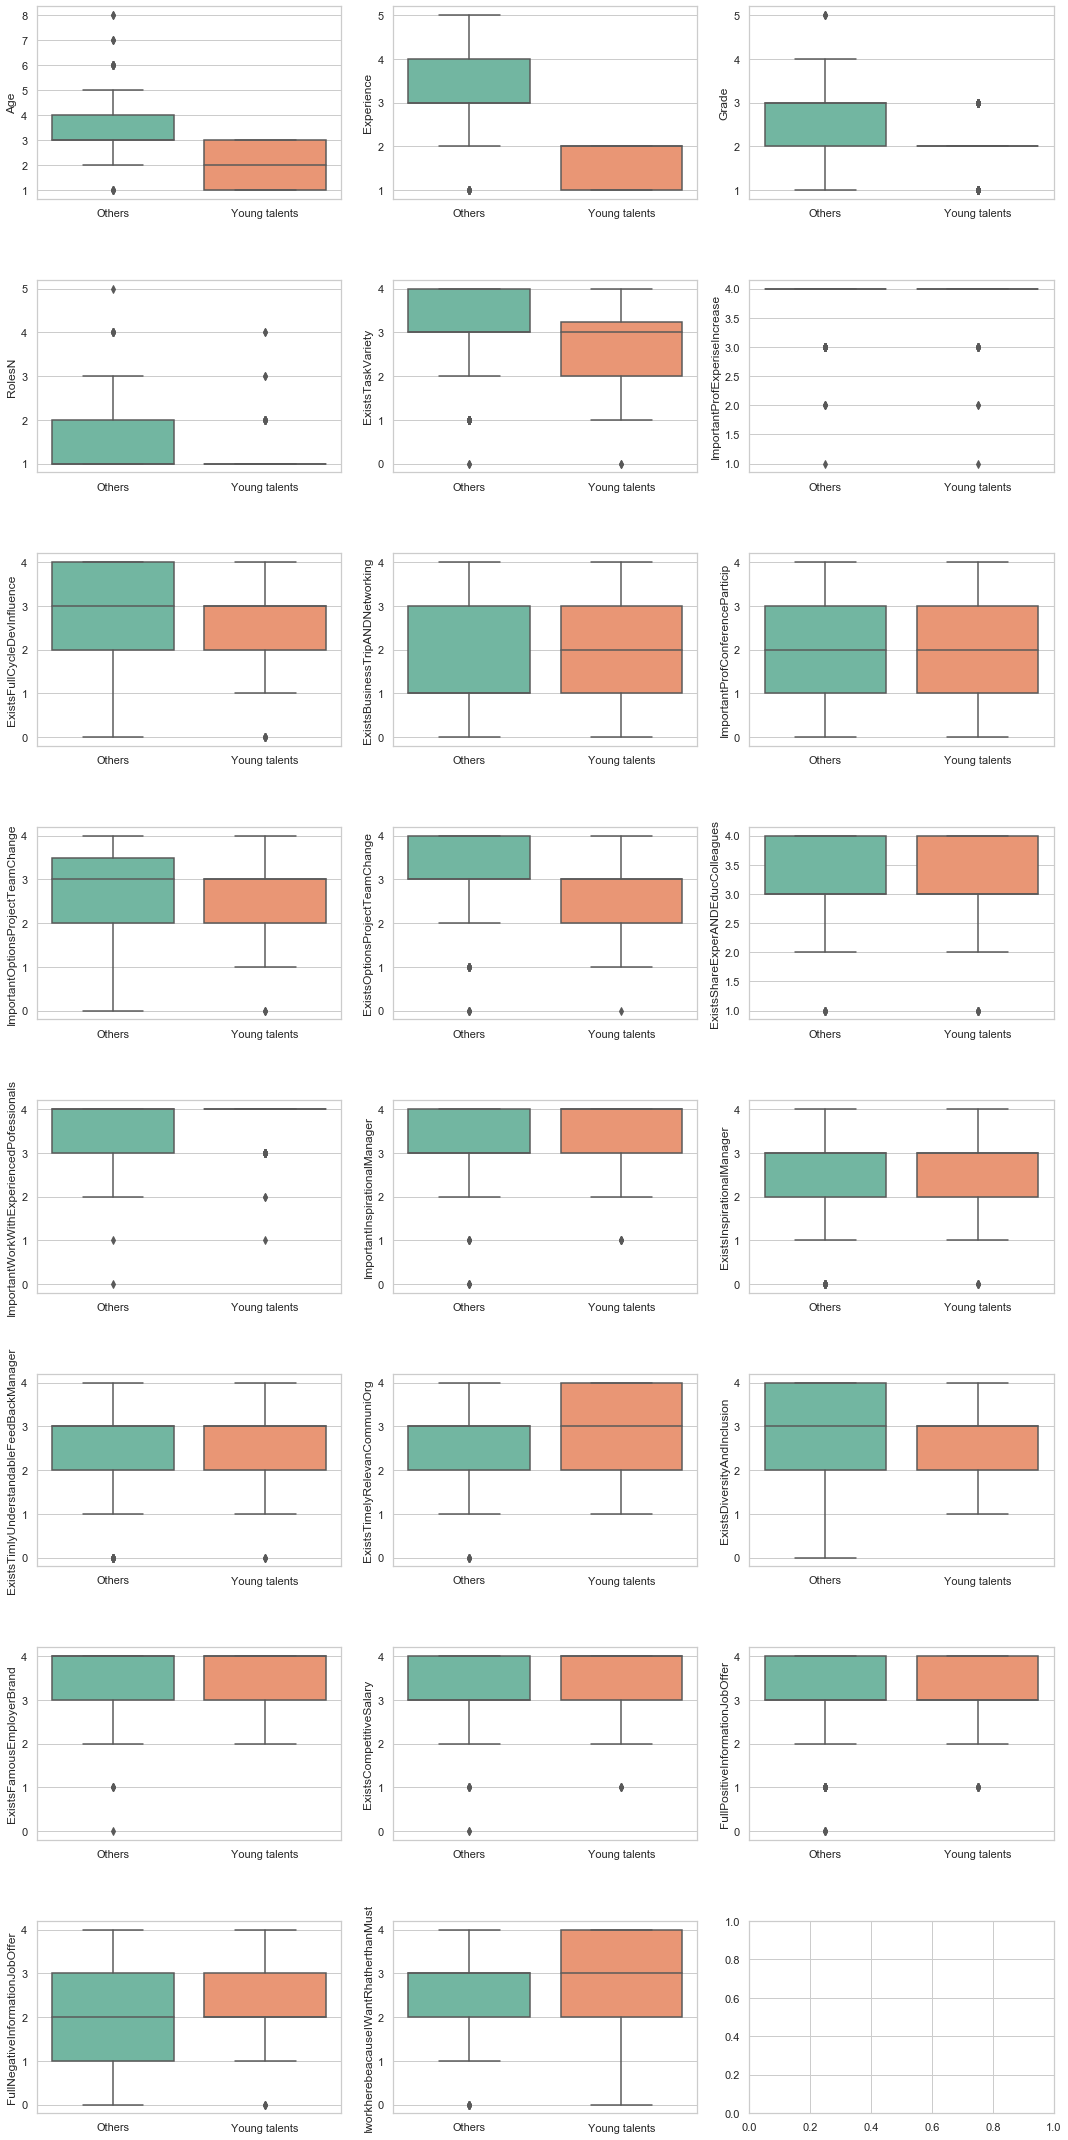

In [59]:
sns.set(style = 'whitegrid')
fig, axes = plt.subplots(round(len(df[num_sign_list].columns) / 3), 3, figsize=(15, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df[num_sign_list].columns):
        sns.boxplot(x=df['Talents'], y=df[num_sign_list].iloc[:, i], ax = ax, palette='Set2')
        ax.set_xlabel('')
        ax.set_xticklabels(labels = ['Others', 'Young talents'])

fig.tight_layout()

### Отрисовка барплотов по категориям

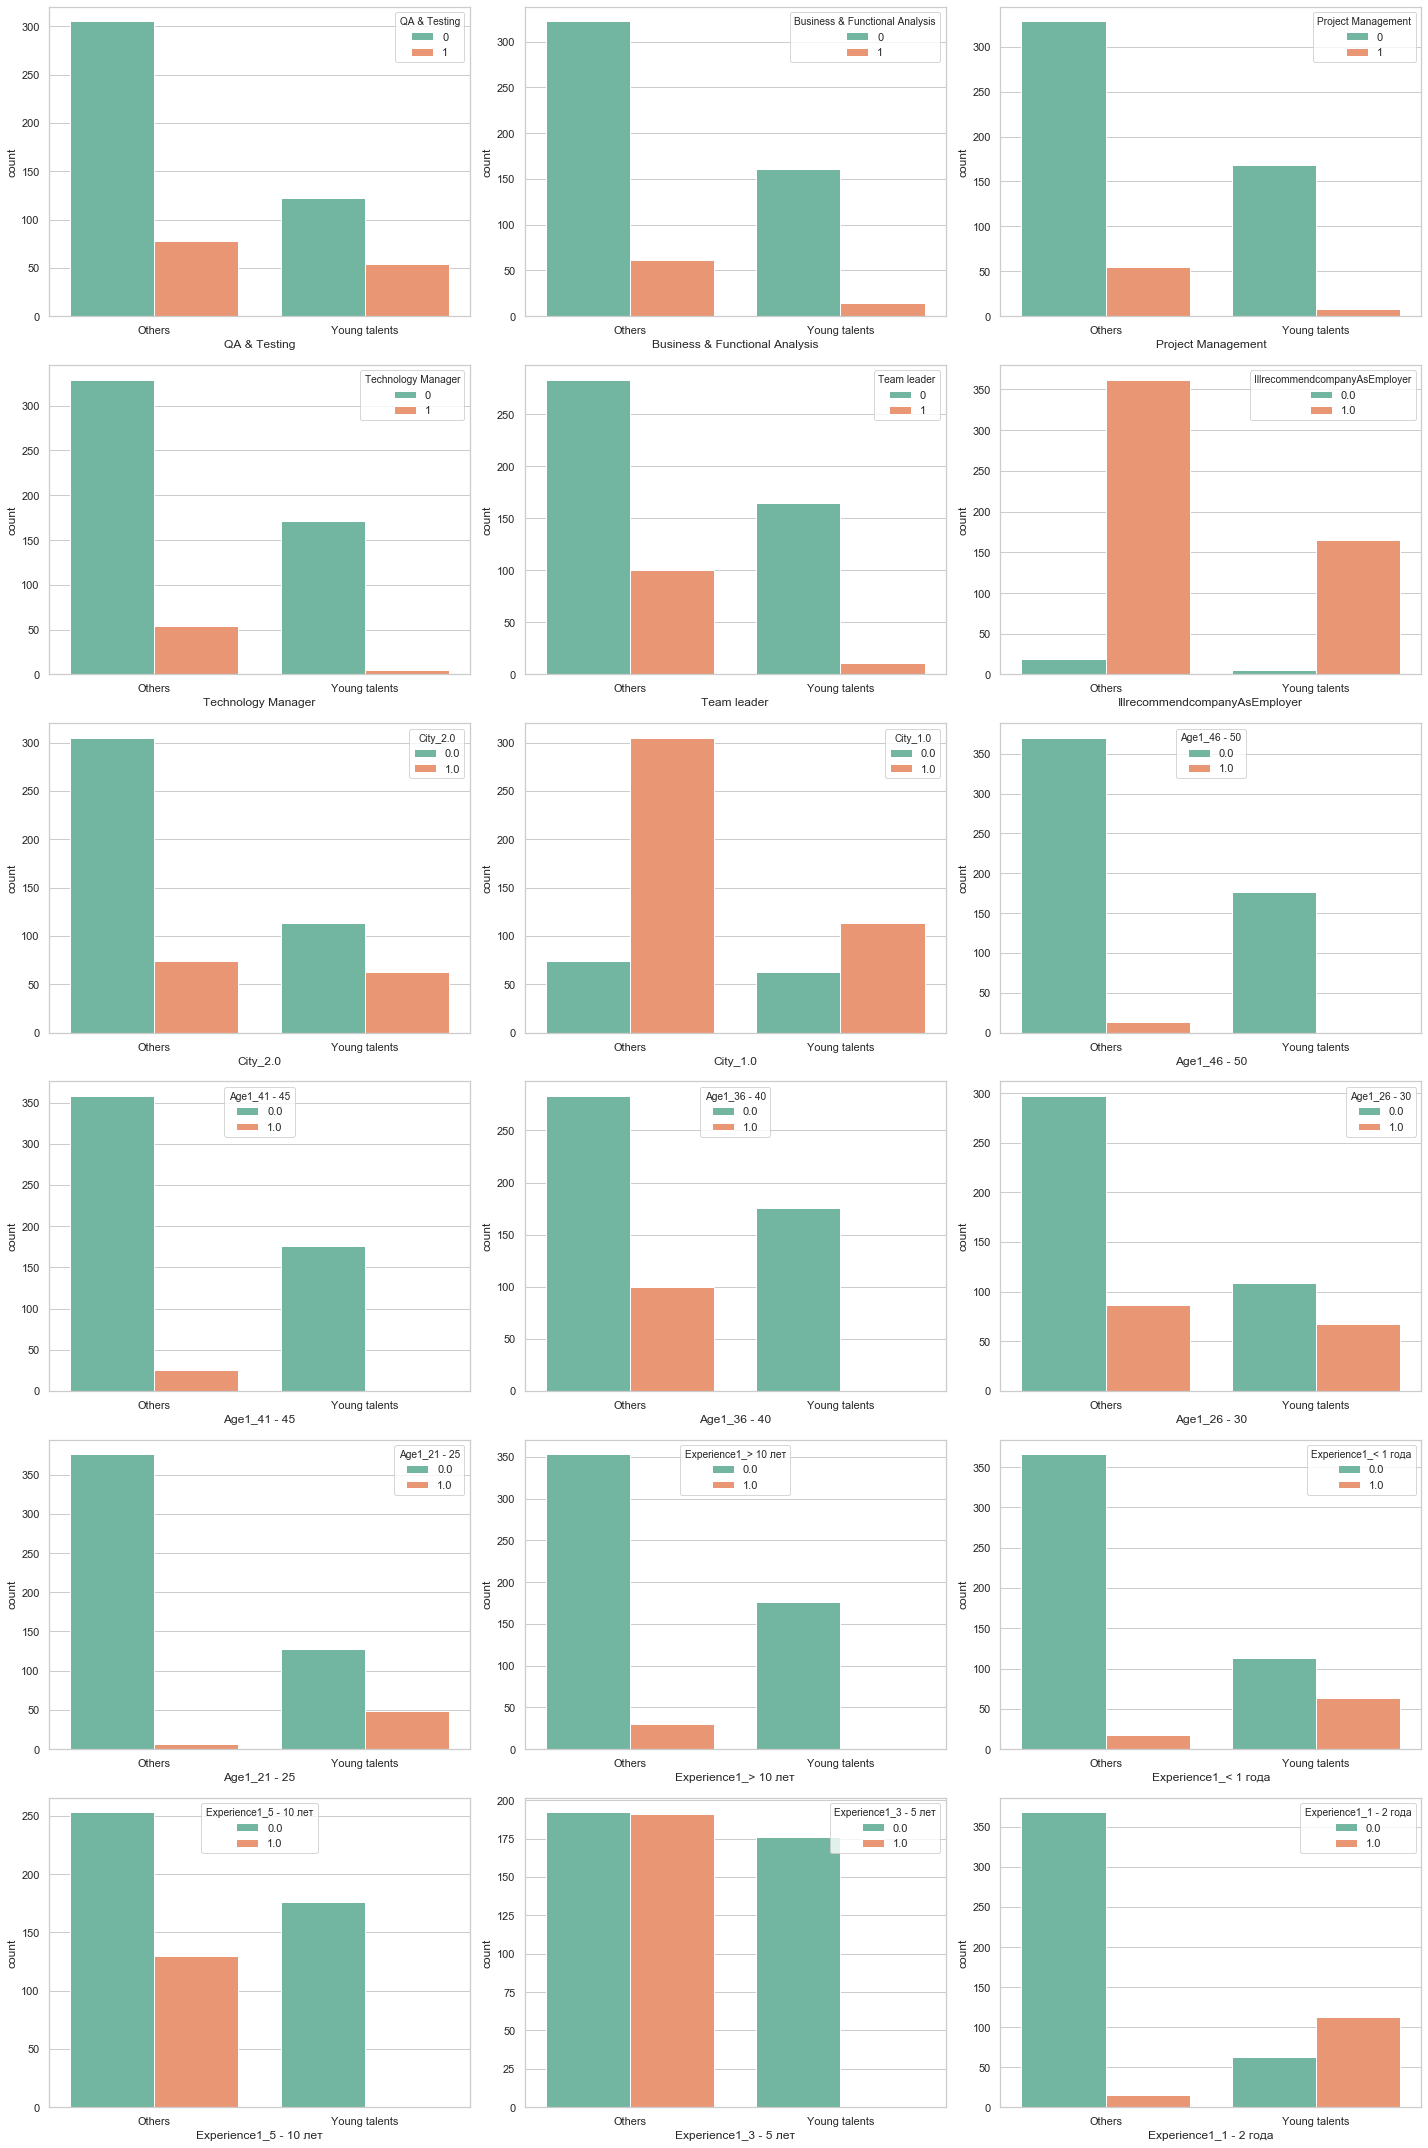

In [60]:
# создаем список категориальных значимых переменных из таблицы выше
cat_list = [x for x in df[signif_list].columns if len(pd.unique(df[signif_list][x].dropna())) < 3]

fig, axes = plt.subplots(round(len(df[cat_list].columns) / 3), 3, figsize=(20, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df[cat_list].columns):
        sns.countplot(x = 'Talents', hue = df[cat_list].iloc[:, i].name, data = df, ax = ax, palette= 'Set2')
        ax.set_xlabel(df[cat_list].iloc[:, i].name)
        ax.set_xticklabels(labels = ['Others', 'Young talents'])

fig.tight_layout()

## Сравнение Важно и Существует

In [66]:
df.groupby('Talents').agg(['median', 'min', 'max']).T

Talents                                                      0    1
Age                                                median  3.0  2.0
                                                   min     1.0  1.0
                                                   max     8.0  3.0
Experience                                         median  3.0  2.0
                                                   min     1.0  1.0
                                                   max     5.0  2.0
Grade                                              median  3.0  2.0
                                                   min     1.0  1.0
                                                   max     5.0  3.0
RolesN                                             median  1.0  1.0
                                                   min     1.0  1.0
                                                   max     5.0  4.0
Software Development                               median  1.0  1.0
                                                   min     0.0  0.0
                                                   max     1.0  1.0
QA & Testing                                       median  0.0  0.0
                                                   min     0.0  0.0
                                                   max     1.0  1.0
Business & Functional Analysis                     median  0.0  0.0
                                                   min     0.0  0.0
                                                   max     1.0  1.0
Infrastructure                                     median  0.0  0.0
                                                   min     0.0  0.0
                                                   max     1.0  1.0
Project Management                                 median  0.0  0.0
                                                   min     0.0  0.0
                                                   max     1.0  1.0
Technology Manager                                 median  0.0  0.0
                                                   min     0.0  0.0
                                                   max     1.0  1.0
Admin (COO, HR, Finance)                           median  0.0  0.0
                                                   min     0.0  0.0
                                                   max     1.0  1.0
Team leader                                        median  0.0  0.0
                                                   min     0.0  0.0
                                                   max     1.0  1.0
ImportantTaskVariety                               median  4.0  4.0
                                                   min     1.0  2.0
                                                   max     4.0  4.0
ExistsTaskVariety                                  median  3.0  3.0
                                                   min     0.0  0.0
                                                   max     4.0  4.0
ImportantProfExperiseIncrease                      median  4.0  4.0
                                                   min     1.0  1.0
                                                   max     4.0  4.0
ExistsProfExperiseIncrease                         median  3.0  3.0
                                                   min     0.0  0.0
                                                   max     4.0  4.0
ImportantCareerLadderPromot                        median  4.0  4.0
                                                   min     0.0  1.0
                                                   max     4.0  4.0
ExistsCareerLadderPromot                           median  2.0  2.0
                                                   min     0.0  0.0
                                                   max     4.0  4.0
ImportantFullCycleDevInfluence                     median  3.0  3.0
                                                   min     0.0  0.0
                                                   max     4.0  4.0
ExistsFullCycleDevInfluence                        media

In [71]:
groups = df.groupby('Talents').agg(['median', 'min', 'max']).T
groups.to_excel('groups.xlsx')

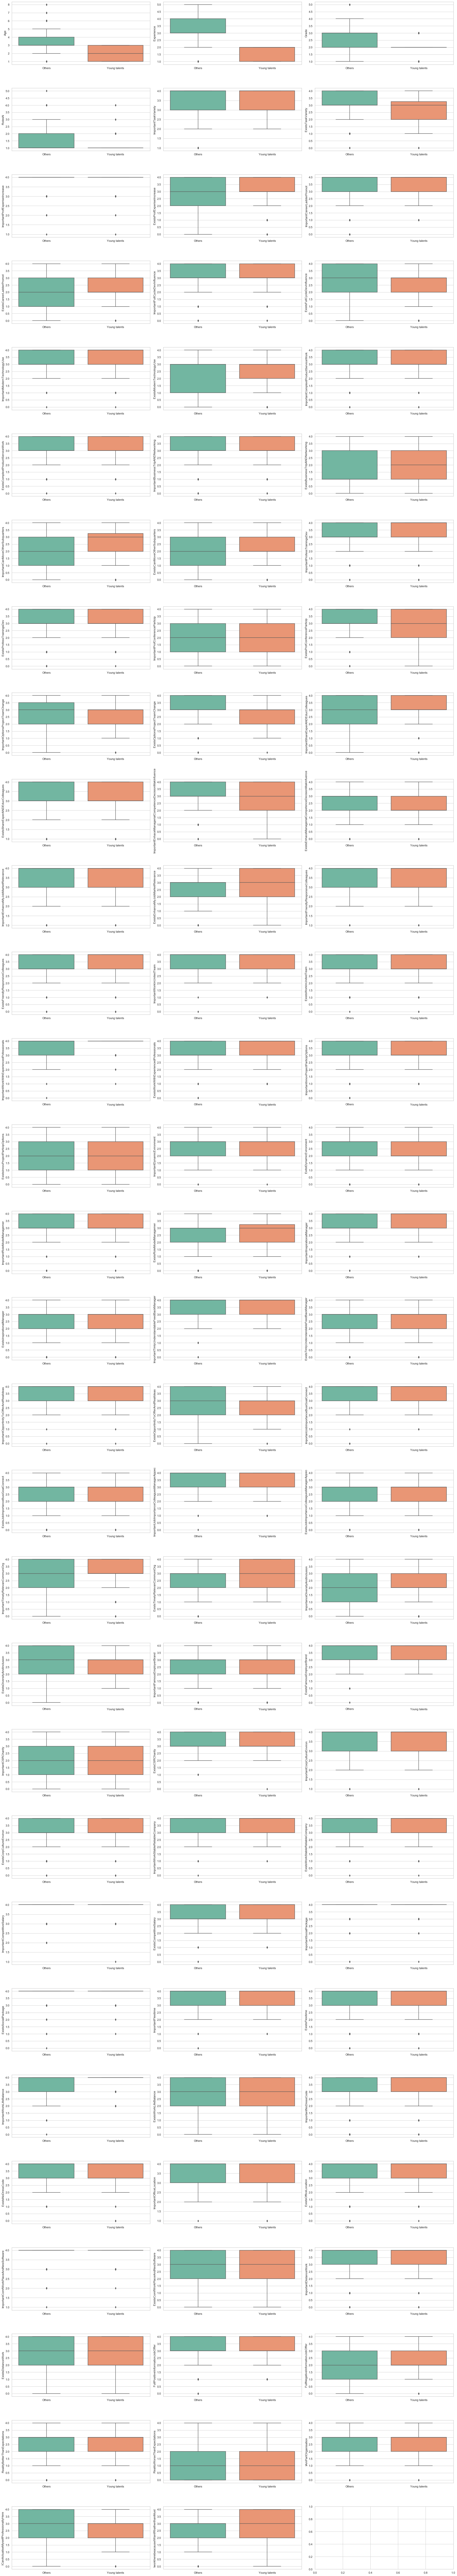

In [80]:
sns.set(style = 'whitegrid')
fig, axes = plt.subplots(round(len(df[num_list].columns) / 3), 3, figsize=(25, 140))

for i, ax in enumerate(fig.axes):
    if i < len(df[num_list].columns):
        sns.boxplot(x=df['Talents'], y=df[num_list].iloc[:, i], ax = ax, palette='Set2')
        ax.set_xlabel('')
        ax.set_xticklabels(labels = ['Others', 'Young talents'])

fig.tight_layout()

### Корреляции по Спирману

только по числовым переменным

In [6]:
num_list = [x for x in df[df['Talents'] == 1].columns if len(pd.unique(df[df['Talents'] == 1][x].dropna())) > 2]

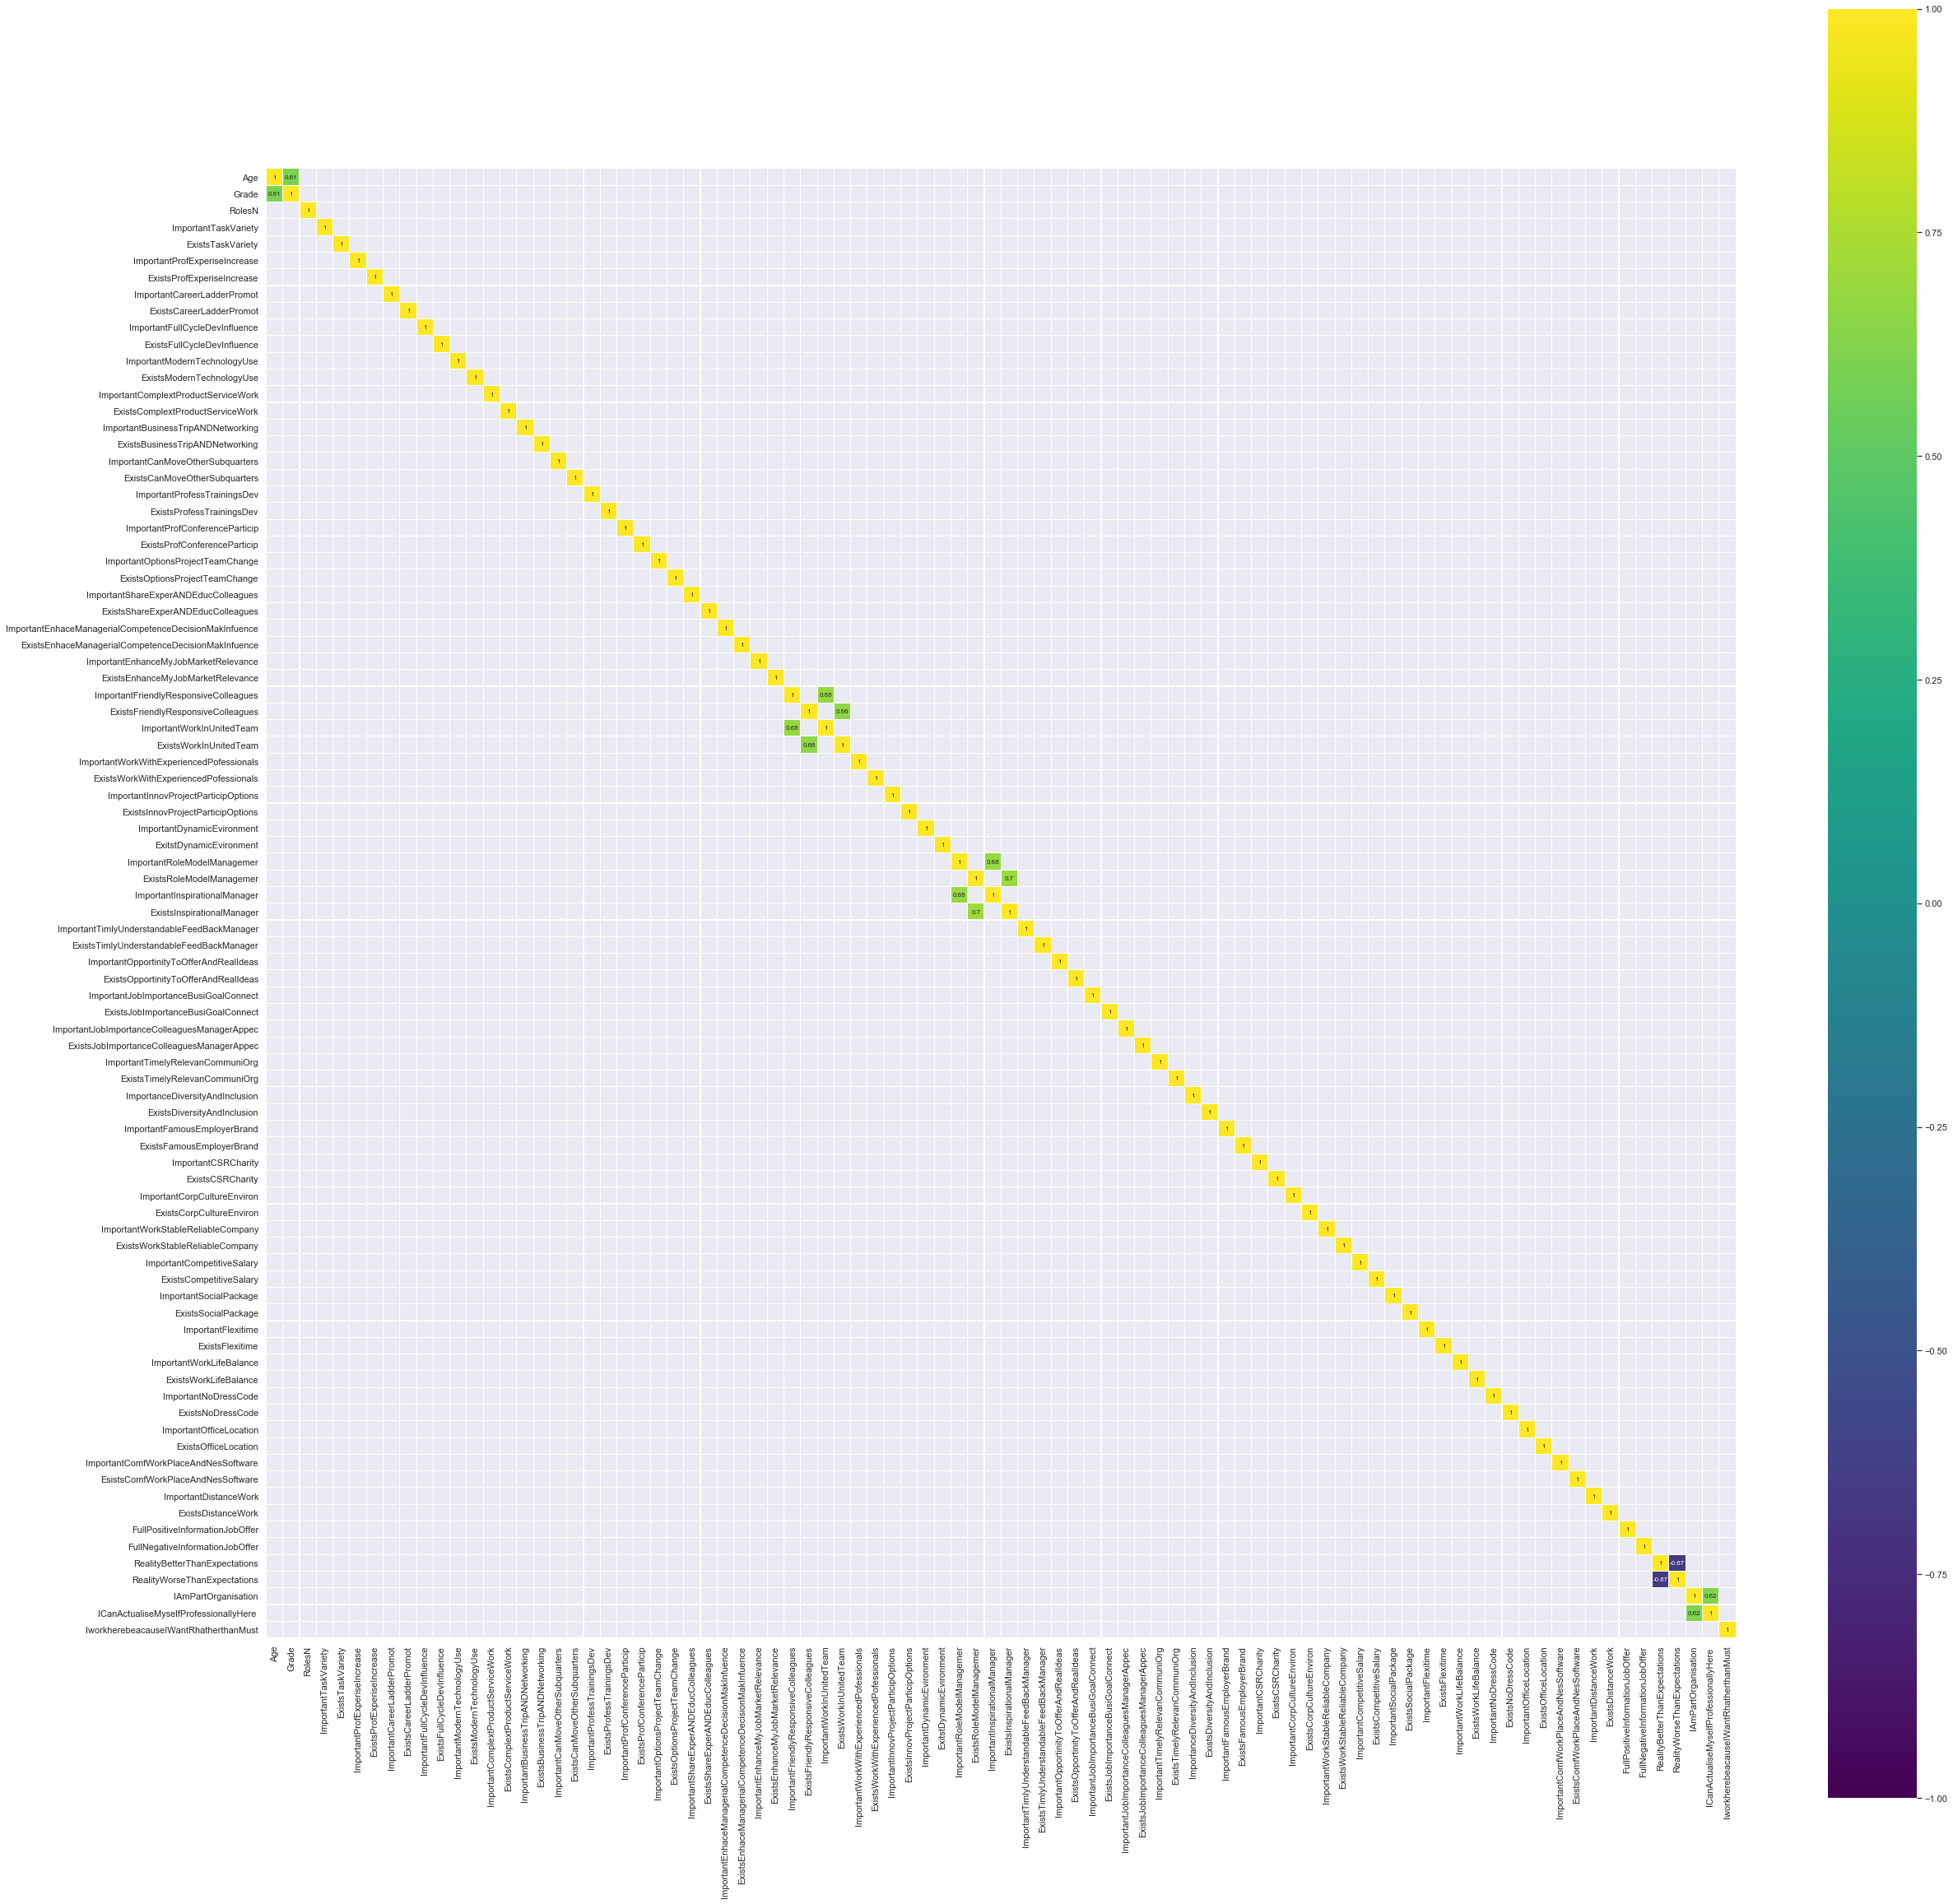

In [7]:
corr = df[num_list][df['Talents'] == 1].corr(method='spearman')

sns.set(style = 'darkgrid')

plt.figure(figsize=(40, 40))

sns.heatmap(corr[(corr >= 0.6) | (corr <= -0.59)], cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True)
plt.show()

In [37]:
corr[(corr >= 0.3) | (corr <= -0.29)]

,Age,Grade,RolesN,ImportantTaskVariety,ExistsTaskVariety,ImportantProfExperiseIncrease,ExistsProfExperiseIncrease,ImportantCareerLadderPromot,ExistsCareerLadderPromot,ImportantFullCycleDevInfluence,ExistsFullCycleDevInfluence,ImportantModernTechnologyUse,ExistsModernTechnologyUse,ImportantComplextProductServiceWork,ExistsComplextProductServiceWork,ImportantBusinessTripANDNetworking,ExistsBusinessTripANDNetworking,ImportantCanMoveOtherSubquarters,ExistsCanMoveOtherSubquarters,ImportantProfessTrainingsDev,ExistsProfessTrainingsDev,ImportantProfConferenceParticip,ExistsProfConferenceParticip,ImportantOptionsProjectTeamChange,ExistsOptionsProjectTeamChange,ImportantShareExperANDEducColleagues,ExistsShareExperANDEducColleagues,ImportantEnhaceManagerialCompetenceDecisionMakInfuence,ExistsEnhaceManagerialCompetenceDecisionMakInfuence,ImportantEnhanceMyJobMarketRelevance,ExistsEnhanceMyJobMarketRelevance,ImportantFriendlyResponsiveColleagues,ExistsFriendlyResponsiveColleagues,ImportantWorkInUnitedTeam,ExistsWorkInUnitedTeam,ImportantWorkWithExperiencedPofessionals,ExistsWorkWithExperiencedPofessionals,ImportantInnovProjectParticipOptions,ExistsInnovProjectParticipOptions,ImportantDynamicEvironment,ExitstDynamicEvironment,ImportantRoleModelManagemer,ExistsRoleModelManagemer,ImportantInspirationalManager,ExistsInspirationalManager,ImportantTimlyUnderstandableFeedBackManager,ExistsTimlyUnderstandableFeedBackManager,ImportantOpportinityToOfferAndRealIdeas,ExistsOpportinityToOfferAndRealIdeas,ImportantJobImportanceBusiGoalConnect,ExistsJobImportanceBusiGoalConnect,ImportantJobImportanceColleaguesManagerAppec,ExistsJobImportanceColleaguesManagerAppec,ImportantTimelyRelevanCommuniOrg,ExistsTimelyRelevanCommuniOrg,ImportanceDiversityAndInclusion,ExistsDiversityAndInclusion,ImportantFamousEmployerBrand,ExistsFamousEmployerBrand,ImportantCSRCharity,ExistsCSRCharity,ImportantCorpCultureEnviron,ExistsCorpCultureEnviron,ImportantWorkStableReliableCompany,ExistsWorkStableReliableCompany,ImportantCompetitiveSalary,ExistsCompetitiveSalary,ImportantSocialPackage,ExistsSocialPackage,ImportantFlexitime,ExistsFlexitime,ImportantWorkLifeBalance,ExistsWorkLifeBalance,ImportantNoDressCode,ExistsNoDressCode,ImportantOfficeLocation,ExistsOfficeLocation,ImportantComfWorkPlaceAndNesSoftware,EsistsComfWorkPlaceAndNesSoftware,ImportantDistanceWork,ExistsDistanceWork,FullPositiveInformationJobOffer,FullNegativeInformationJobOffer,RealityBetterThanExpectations,RealityWorseThanExpectations,IAmPartOrganisation,ICanActualiseMyselfProfessionallyHere,IworkherebeacauseIWantRhatherthanMust
Age,1.000000,0.607252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Grade,0.607252,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RolesN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ImportantTaskVariety,NaN,NaN,NaN,1.000000,NaN,0.303312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.398902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.347679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [129]:
tablecor = corr[(corr >= 0.3) | (corr <= -0.29)]
tablecor.to_excel('tablecor.xlsx')

## Выводы по корреляциям

* ImportantFriendlyResponsiveColleagues ~ ImportantWorkInUnitedTeam 0,7
* ExistsFriendlyResponsiveColleagues ~ ExistsWorkInUnitedTeam 0,7
* ImportantRoleModelManagemer ~ ImportantInspirationalManager 0,7
* ExistsRoleModelManagemer ~ ExistsInspirationalManager 0,7


* Age ~ Grade 0,6
* IAmPartOrganisation ~ ICanActualiseMyselfProfessionallyHere 0,6
* ExistsProfExperiseIncrease ~ ExistsEnhanceMyJobMarketRelevance 0,6
* ExistsWorkInUnitedTeam ~ ExistsInspirationalManager 0,6
* ImportantDynamicEvironment ~ ExitstDynamicEvironment 0,6
* ExistsInspirationalManager ~ ExistsTimlyUnderstandableFeedBackManager 0,6
* ImportantTimlyUnderstandableFeedBackManager ~ ImportantJobImportanceColleaguesManagerAppec 0,6
* 

* ExistsTaskVariety ~ ExistsProfExperiseIncrease 0,5
* ExistsWorkWithExperiencedPofessionals ~ ExistsProfExperiseIncrease 0,5
* ICanActualiseMyselfProfessionallyHere ~ ExistsProfExperiseIncrease 0,5
* ExistsCareerLadderPromot ~ ExistsFullCycleDevInfluence 0,5
* ExistsCareerLadderPromot ~ ExistsEnhaceManagerialCompetenceDecisionMakInfuence 0,5
* ExistsCareerLadderPromot ~ ExistsJobImportanceColleaguesManagerAppec 0,5
* ExistsModernTechnologyUse ~ ExistsInnovProjectParticipOptions 0,5
* ImportantBusinessTripANDNetworking ~ ImportantCanMoveOtherSubquarters
* ExistsProfessTrainingsDev ~ ExistsProfConferenceParticip
* ImportantFriendlyResponsiveColleagues ~ ImportantWorkWithExperiencedPofessionals
* ExistsFriendlyResponsiveColleagues ~ ExistsWorkWithExperiencedPofessionals
* ExistsFriendlyResponsiveColleagues ~ ExistsRoleModelManagemer
* ExistsFriendlyResponsiveColleagues ~ ExistsInspirationalManager
* ExistsFriendlyResponsiveColleagues ~ ExistsCorpCultureEnviron
и др. переменные, их очень-очень много


* ImportantSocialPackage ~ ImportantCompetitiveSalary 0,5

* ICanActualiseMyselfProfessionallyHere ~ RealityWorseThanExpectations -0,5
* ExistsRoleModelManagemer ~ RealityWorseThanExpectations -0,5
* ExistsCorpCultureEnviron ~ RealityWorseThanExpectations -0,4
* IAmPartOrganisation ~ RealityWorseThanExpectations -0,4
* IworkherebeacauseIWantRhatherthanMust ~ RealityWorseThanExpectations -0,4
* ExistsTaskVariety ~ RealityWorseThanExpectations -0,4
* ExistsProfExperiseIncrease ~ RealityWorseThanExpectations -0,4
* ExistsWorkWithExperiencedPofessionals ~ RealityWorseThanExpectations -0,4
* ExistsInspirationalManager ~ RealityWorseThanExpectations -0,4
* ExistsJobImportanceBusiGoalConnect ~ RealityWorseThanExpectations -0,4
* ExistsJobImportanceColleaguesManagerAppec ~ RealityWorseThanExpectations -0,4
* ExistsInnovProjectParticipOptions ~ RealityWorseThanExpectations -0,3
* ExistsCareerLadderPromot ~ RealityWorseThanExpectations -0,3
* ExistsFullCycleDevInfluence ~ RealityWorseThanExpectations -0,3
* ExistsFriendlyResponsiveColleagues ~ RealityWorseThanExpectations -0,3
* ExistsWorkInUnitedTeam ~ RealityWorseThanExpectations -0,3
* ExistsTimlyUnderstandableFeedBackManager ~ RealityWorseThanExpectations -0,3
* ExistsOpportinityToOfferAndRealIdeas ~ RealityWorseThanExpectations -0,3
* ExistsTimelyRelevanCommuniOrg  ~ RealityWorseThanExpectations -0,3
* ImportantWorkStableReliableCompany ~ RealityWorseThanExpectations -0,3
* EsistsComfWorkPlaceAndNesSoftware ~ RealityWorseThanExpectations -0,3
* `FullNegativeInformationJobOffer` ~ RealityWorseThanExpectations -0,3


* ExistsOfficeLocation вообще ни с чем не коррелирует

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


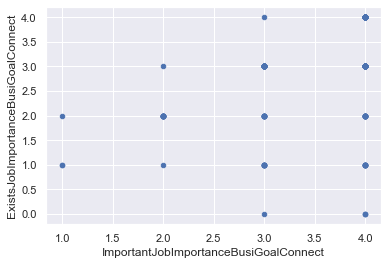

In [8]:
df[df['Talents'] == 1].plot('ImportantJobImportanceBusiGoalConnect', 'ExistsJobImportanceBusiGoalConnect', kind = 'scatter')